In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import openmc_source_plotter
import neutronics_material_maker as nmm
import openmc_source_plotter

In [2]:
#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')
#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')
#cadmium 
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')
#BF3
bf3 = nmm.Material.from_library('Boron Fluoride (BF3)').openmc_material
#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('kg/m3',940)
#polyethylene.add_s_alpha_beta('c_H_in_polyethylene')
materials = openmc.Materials([lead, al, cadmium, bf3, polyethylene])
materials.export_to_xml()

In [39]:
#geometry dimensions
cylinder_radius = 0.054
detector_radius = 0.02
outer_cylinder_radius = 0.125
lead_thickness = 0.0015
shielding_thickness = 0.0015

lead_height = 0.141
b_detector_height = 0.047
cylinder_height = 0.297
big_cd_height = 0.05
small_cd_height = 0.025

cd_thickness = 0.0015
cd_gap = 0.02425

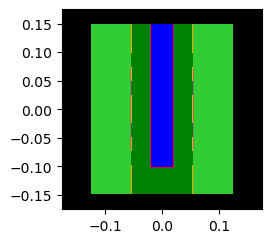

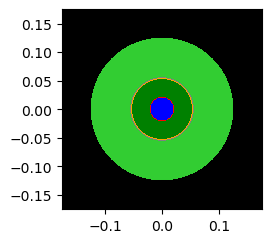

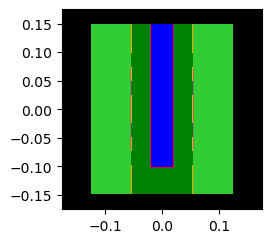

In [50]:
#geometry model

detector = openmc.ZCylinder(r=detector_radius)
shielding = openmc.ZCylinder(r=detector_radius + shielding_thickness)
inner_cylinder = openmc.ZCylinder(r=cylinder_radius)
lead_plate = openmc.ZCylinder(r=cylinder_radius + lead_thickness)
cd_cylinder = openmc.ZCylinder(r=cylinder_radius - (cd_thickness))
outer_cylinder = openmc.ZCylinder(r=outer_cylinder_radius)
source_sphere = openmc.Sphere(r=0.5)
outer_void = openmc.Sphere(r=0.55, boundary_type='vacuum')

top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height)
bottom_shielding = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height-shielding_thickness)
top_lead = openmc.ZPlane(z0=0.5*lead_height)
bottom_lead = openmc.ZPlane(z0=-0.5*lead_height)
top_wall_cylinder = openmc.ZPlane(z0=0.5*cylinder_height+0.001)

cd_cylinder_region = +cd_cylinder & -inner_cylinder 
cd_bottom_1 = openmc.ZPlane(0.5*cylinder_height-big_cd_height)
cd_top_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap)
cd_bottom_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height)
cd_top_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap)
cd_bottom_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap-big_cd_height)
cd_top_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap+small_cd_height)
cd_bottom_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap)
cd_top_5 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height)

cd_1 = cd_cylinder_region & -top_cylinder & +cd_bottom_1
cd_2 = cd_cylinder_region & -cd_top_2 & +cd_bottom_2
cd_3 = cd_cylinder_region & -cd_top_3 & +cd_bottom_3
cd_4 = cd_cylinder_region & -cd_top_4 & +cd_bottom_4
cd_5 = cd_cylinder_region & -cd_top_5 & +bottom_cylinder
cd_region = cd_1 | cd_2 | cd_3 | cd_4 | cd_5

detector_region = -detector & -top_cylinder & +bottom_detector
shielding_region = (-shielding & -top_cylinder & +bottom_shielding & +detector) | ( -detector & +bottom_shielding & -bottom_detector)

inner_polyethylene_region = ((-inner_cylinder & + shielding & -top_cylinder & +bottom_cylinder) | (-shielding & -bottom_shielding & +bottom_cylinder)) & ~cd_region

lead_region = -lead_plate & -top_lead & +bottom_lead & + inner_cylinder
outer_polyethylene_region = (-outer_cylinder & -top_cylinder & +bottom_cylinder & ~lead_region & +inner_cylinder ) | (-top_wall_cylinder & +top_cylinder & - outer_cylinder)
sphere_region = (-source_sphere & +outer_cylinder) | (+top_wall_cylinder & -source_sphere) | (-bottom_cylinder & -source_sphere)
outer_void_region = +source_sphere & -outer_void

detector_cell = openmc.Cell(region=detector_region, fill=bf3)
shielding_cell = openmc.Cell(region=shielding_region, fill=al)
inner_polyethylene_cell = openmc.Cell(region=inner_polyethylene_region, fill=polyethylene)
lead_cell = openmc.Cell(region=lead_region, fill=lead)
cd_cell = openmc.Cell(region =cd_region, fill = cadmium)
outer_polyethylene_cell = openmc.Cell(region=outer_polyethylene_region, fill=polyethylene)
source_cell = openmc.Cell(region=sphere_region)
outer_void_cell = openmc.Cell(region=outer_void_region)

universe = openmc.universe = openmc.Universe(cells=[detector_cell, shielding_cell, inner_polyethylene_cell, lead_cell, cd_cell, outer_polyethylene_cell, source_cell, outer_void_cell])


x,y = 0.35,0.35
color_assignment = {detector_cell : 'blue',
                    shielding_cell : 'red',
                    inner_polyethylene_cell : 'green',
                    cd_cell : 'orange',
                    lead_cell : 'grey',
                    outer_polyethylene_cell :'limegreen',
                   source_cell : 'black'}
plt.show(universe.plot(width=(x, y), basis='xz',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='xy',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='yz',  colors=color_assignment))

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

In [18]:
# makes the 3d "cube" style geometry
vox_plot = openmc.Plot()
vox_plot.type = 'voxel'
vox_plot.width = (1,1,1)
vox_plot.pixels = (300,300,300)
vox_plot.filename = 'plot_lupin'
vox_plot.color_by = 'material'
# vox_plot.colors = {copper: 'blue'}  # materials can be coloured using this command
plots = openmc.Plots([vox_plot])
plots.export_to_xml()

openmc.plot_geometry()
#import os
#os.system('openmc-voxel-to-vtk plot_lupin.h5 -o plot_lupin.vti')

#from IPython.display import FileLink
#display(FileLink('plot_lupin.vti'))

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [51]:
#ambe source tabular distribution
x = [0.414,110000, 330000, 540000, 750000,
     970000.97, 1180001.18, 1400001.4,	1610001.61,	1820001.82,
     2040004.08, 2250004.5,	2470004.94,	2680005.36,	2900005.8,
     3110009.33,	3320009.96,	3540010.62,	3750011.25,	3970011.91,
     4180016.72,	4390017.56,	4610018.44,	4820019.28,	5040020.16,
     5250026.25,	5470027.35,	5680028.4,	5890029.45,	6110030.55,
     6320037.92,	6540039.24,	6750040.5,	6960041.76,	7180043.08,
     7390051.73,	7610053.27,	7820054.74,	8030056.21,	8250057.75,
     8460067.68,	8680069.44,	8890071.12,	9110072.88,	9320074.56,
     9530085.77,	9750087.75,	9960089.64,	10200091.8,	10400093.6,
     10600106, 10800108,  11000110]
p = [1.15E-03,  3.04E-02,  6.36E-02,  8.55E-02,  9.72E-02,
       1.09E-01,  1.16E-01,  1.25E-01,  1.57E-01,  1.95E-01,
       2.19E-01,  2.41E-01,  2.79E-01,  3.74E-01,  5.09E-01, 
       5.65E-01,  5.39E-01,  5.33E-01,  5.26E-01,  5.22E-01,
       5.83E-01,  6.50E-01,  6.89E-01,  7.46E-01,  7.45E-01,
       6.67E-01,  6.18E-01,  5.67E-01,  4.96E-01,  5.24E-01,
       5.96E-01,  5.79E-01,  5.32E-01,  5.40E-01,  5.83E-01,
       6.41E-01,  6.76E-01,  6.38E-01,  5.33E-01,  3.85E-01,
       2.54E-01,  1.78E-01,  1.50E-01,  1.67E-01,  2.27E-01,
       2.74E-01,  2.59E-01,  1.97E-01,  1.91E-01,  1.46E-01,
       8.08E-02,  1.98E-02,  0.00E+00]

In [56]:
#now create the source
#spherical source enclosing the detector
sett = openmc.Settings()
sett.particles = 10000
sett.batches = 5
sett.inactive = 0
sett.run_mode = 'fixed source'

sphere_source = openmc.Source()

phi_angle = openmc.stats.Uniform(a=0., b= 2*3.14159265359)
theta_angle = openmc.stats.Uniform(a=0., b= 2*3.14159265359)
source_distance = openmc.stats.Discrete([-0.5, 0.5], [0.5,0.5]) #m away from the lupin detector

sphere_source.particle = 'neutron'

sphere_source.energy = openmc.stats.Tabular(x,p)


#sphere_source.energy = openmc.stats.Discrete([14e6],[1])
sphere_source.angle = openmc.stats.Isotropic()
sphere_source.space = openmc.stats.Point((0,-0.5,0))
#sphere_source.space = openmc.stats.SphericalIndependent(source_distance, theta_angle, phi_angle, origin=(0.0, 0.0, 0.0))
sett.source = sphere_source

#sphere_source.plot_source_energy()


In [57]:
#now create a tally to calibrate the detector
tallies = openmc.Tallies()
neutron_particle_filter = openmc.ParticleFilter(['neutron'])

energy_filter = openmc.EnergyFilter(np.linspace(0,12e6,300))
detector_cell_filter = openmc.CellFilter(detector_cell)
detector_tally = openmc.Tally(name='detector_tally')
detector_tally.scores = ['flux']
detector_tally.filters = [detector_cell_filter, neutron_particle_filter, energy_filter]
tallies.append(detector_tally)


In [15]:
#inelastic (n,alpha) reaction between neutrons and 10B


detector_n_alpha_tally = openmc.Tally(name='detector_n_alpha_tally')
detector_n_alpha_tally.scores = ['(n,a)']
detector_n_alpha_tally.filters = [detector_cell_filter]

tallies.append(detector_n_alpha_tally)

In [10]:
#test tallies working

In [58]:
model = openmc.model.Model(geometry, materials, sett, tallies)
# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [59]:
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
cell_tally = results.get_tally(name='detector_tally')
df = cell_tally.get_pandas_dataframe()
df


,cell,particle,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,192,neutron,0.000000e+00,4.013378e+04,total,flux,0.0,0.0
1,192,neutron,4.013378e+04,8.026756e+04,total,flux,0.0,0.0
2,192,neutron,8.026756e+04,1.204013e+05,total,flux,0.0,0.0
3,192,neutron,1.204013e+05,1.605351e+05,total,flux,0.0,0.0
4,192,neutron,1.605351e+05,2.006689e+05,total,flux,0.0,0.0
...,...,...,...,...,...,...,...,...
294,192,neutron,1.179933e+07,1.183946e+07,total,flux,0.0,0.0
295,192,neutron,1.183946e+07,1.187960e+07,total,flux,0.0,0.0
296,192,neutron,1.187960e+07,1.191973e+07,total,flux,0.0,0.0
297,192,neutron,1.191973e+07,1.195987e+07,total,flux,0.0,0.0


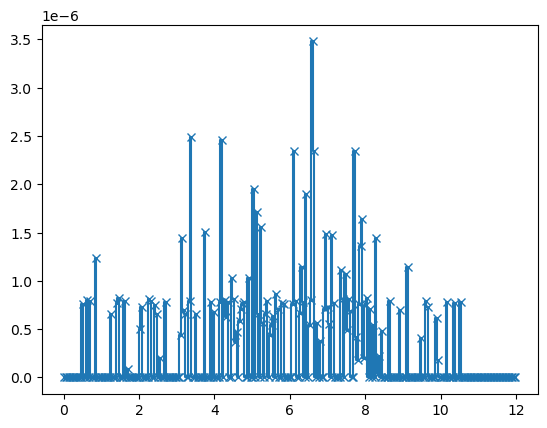

In [60]:
energy_midpoints = (df['energy high [eV]'] + df['energy low [eV]']) /2
curr = cell_tally.mean.ravel()
plt.step(energy_midpoints/10**6, curr, marker='x')